# Predict auction price

Try several models and improve predicition accuracy

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [2]:
# set figure defaults (needs to be in cell seperate from import sns)
matplotlib.rcParams['font.sans-serif'] = ['Helvetica','Arial', 'sans-serif']
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['figure.titlesize'] = 24
matplotlib.rcParams['font.size'] = 18

# Load data

In [3]:
fn = '../data/cars-for-ml.pkl'
print(fn)
df = pd.read_pickle(fn)

# categories
cat_columns = ['brand', 'model', 'fuel', 'body_type','color', 'energy_label', 'fwd']
# numerical
num_columns = list(pd.np.setdiff1d(df.columns, cat_columns + ['price']))

# Factorized categorical values
fld = 'energy_label'
# replace empty with NaN creates factor '-1'
v, idx = pd.factorize(df[fld].replace({'': pd.np.NaN}), sort=True)
# convert '-1' back to NaN
v = v.astype(float)
v[v==-1] = pd.np.NaN
# Store in dataframe
new_col = 'converted_' + fld
df[new_col] = v
# update list
num_columns += [new_col]
cat_columns.remove(fld)
print('\nCategorical field [{}] is converted to sequential numbers with: '.format(fld), end='\n\t')
print(*['{} <'.format(c) for c in idx], end='\n\n')

# convert boolean to numerical
fld = 'fwd'
new_col = fld
# # update list
# cat_columns += [new_col]
# cat_columns.remove(fld)
replace_dict = {
    '': '', 
    True: 'y', 
    False: 'n'
}
df[new_col] = df[fld].replace(replace_dict)
print('\nBoolean field [{}] is converted to numbers according to: '.format(fld), end='\n')
print(*['\t"{}" -> {} ({})\n'.format(k,v, type(v)) for k,v in replace_dict.items()], end='\n\n')

# convert integer to float and replace -1
for fld in ['number_of_cylinders', 'number_of_doors', 'number_of_gears', 'number_of_seats']:
    new_col = fld
    replace_dict = {
        -1: pd.np.NaN, 
    }
    df[new_col] = df[fld].replace(replace_dict).astype(float)

# convert empty string to NaN
for fld in ['brand', 'model', 'fuel', 'body_type', 'color', 'fwd']:
    new_col = fld
    replace_dict = {
        '': pd.np.NaN, 
    }
    df[new_col] = df[fld].replace(replace_dict)

# translate Dutch to English
fld = 'color'
new_col = fld
# # update list
# cat_columns += [new_col]
# cat_columns.remove(fld)
replace_dict = {
    '': 'missing', 
    'BLAUW': 'Blue',
    'ROOD': 'Red',
    'GROEN': 'Green',
    'GRIJS': 'Gray',
    'WIT': 'White',
    'ZWART': 'Black',
    'BEIGE': 'Beige',
    'BRUIN': 'Brown',
    'ROSE': 'Pink',
    'GEEL': 'Yellow',
    'CREME': 'Creme',
    'ORANJE': 'Orange',
    'PAARS': 'Purple,'
}
df[new_col] = df[fld].replace(replace_dict)
print('\nField [{}] is converted according to: '.format(fld), end='\n')
print(*['\t"{}" -> {} ({})\n'.format(k,v, type(v)) for k,v in replace_dict.items()], end='\n\n')

# reporting
print('Categorical:', len(cat_columns))
[print('\t[{:2.0f}] {:s}'.format(i+1, c)) for i,c in enumerate(df[cat_columns].columns)]
print('Numercial:', len(num_columns))
[print('\t[{:2.0f}] {:s}'.format(i+1, c)) for i,c in enumerate(df[num_columns].columns)]
print('Last lot in data set:\n\t{}'.format(df.index[-1]))


../data/cars-for-ml.pkl

Categorical field [energy_label] is converted to sequential numbers with: 
	A < B < C < D < E < F < G <


Boolean field [fwd] is converted to numbers according to: 
	"" ->  (<class 'str'>)
 	"True" -> y (<class 'str'>)
 	"False" -> n (<class 'str'>)



Field [color] is converted according to: 
	"" -> missing (<class 'str'>)
 	"BLAUW" -> Blue (<class 'str'>)
 	"ROOD" -> Red (<class 'str'>)
 	"GROEN" -> Green (<class 'str'>)
 	"GRIJS" -> Gray (<class 'str'>)
 	"WIT" -> White (<class 'str'>)
 	"ZWART" -> Black (<class 'str'>)
 	"BEIGE" -> Beige (<class 'str'>)
 	"BRUIN" -> Brown (<class 'str'>)
 	"ROSE" -> Pink (<class 'str'>)
 	"GEEL" -> Yellow (<class 'str'>)
 	"CREME" -> Creme (<class 'str'>)
 	"ORANJE" -> Orange (<class 'str'>)
 	"PAARS" -> Purple, (<class 'str'>)


Categorical: 6
	[ 1] brand
	[ 2] model
	[ 3] fuel
	[ 4] body_type
	[ 5] color
	[ 6] fwd
Numercial: 18
	[ 1] age
	[ 2] age_at_import
	[ 3] days_since_inspection_invalid
	[ 4] displacement
	[ 5] heig

In [4]:
# Store model results in dictonary: Instantiate empty dict
models = dict()

- - - - - 
# Model: Simple linear fit
Regress age (in days) with price (euro).  

## >> BIG FAT WARNING <<
All data is used without train / test split. I.e. accuracy is based on data that was used for fit. This is considered bad practice!

## Prepare input

In [5]:
from sklearn import linear_model

model_name = 'linear regression no cv'

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = df.dropna(subset=['price','age']).price.values.reshape(-1,1)
print(X.shape)
print(y.shape)

(3474, 1)
(3474, 1)


## Fit

In [6]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})

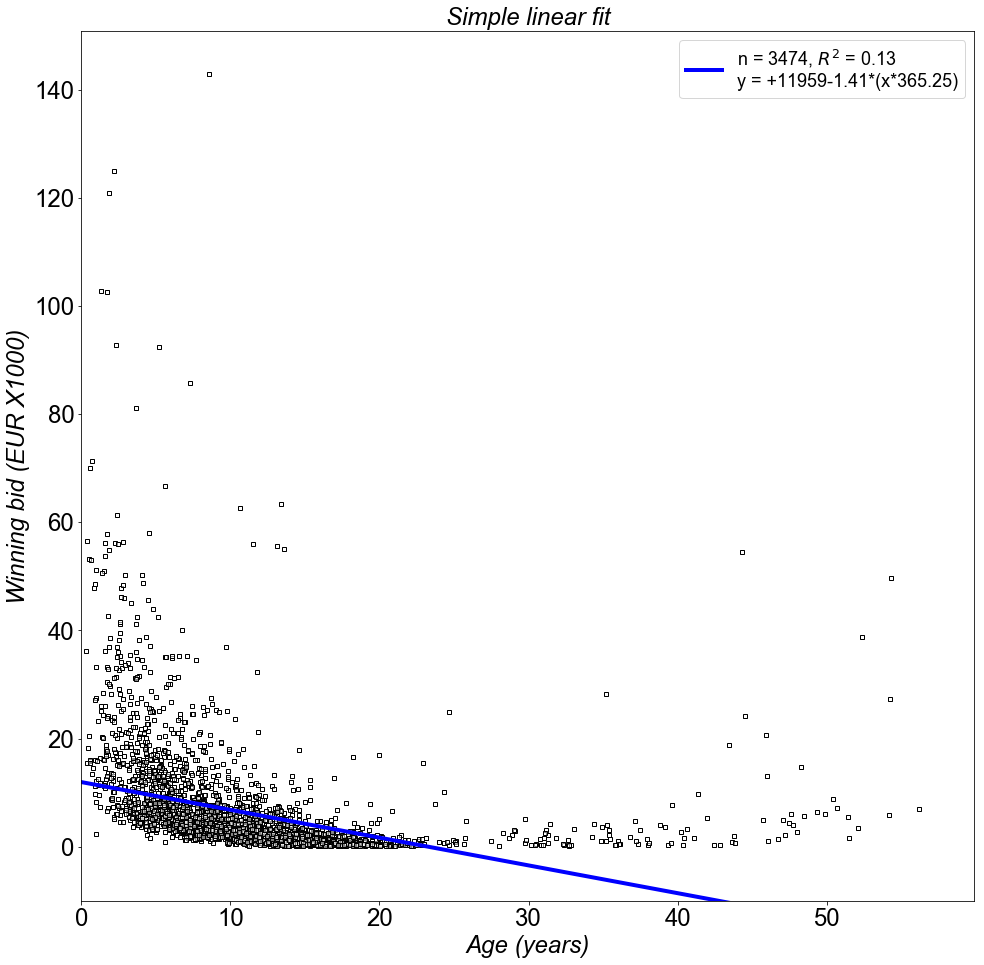

In [7]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
plt.plot(X/365.25, y/1000, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4)
hdl_fit = plt.plot(prediction_X/365, prediction_y/1000, color='blue', marker=None, linestyle='-', linewidth=4)
plt.legend(hdl_fit, ['n = {}, $R^2$ = {:.2f}\ny = {:+.0f}{:+.2f}*(x*365.25)'.format(
    models[model_name]['n'],
    models[model_name]['R^2'],
    *models[model_name]['betas']
)], loc='upper right')
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR X1000)', style='italic')
plt.title('Simple linear fit', style='italic')
plt.ylim(bottom = -10)
plt.xlim(left = 0)

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

## Model: linear but with scaled dependent values (prices)

Instead of using all data **train/test split** is performed. Also prices are log transformed.  

## Prepare input

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score

model_name = 'linear regression log price'

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = pd.np.log10(df.dropna(subset=['price','age']).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(3474, 1)
(3474, 1)


## Fit

In [9]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(2431, 1)
(1043, 1)


In [10]:
depr_half_n_days = -(pd.np.log10(2)/models[model_name]['betas'][1])
print('According to "{}"-model'.format(model_name))
print('Car depreciates to half its value every\n\t{:.0f} days ({:.1f} years).'.format(depr_half_n_days, depr_half_n_days/365.25))
for y in [0,2,4,6,8]:
    print('\ty(t={:+5.0f}) = {:.0f} euro'.format(y, 10**reg.predict([[y*365.25]])[0][0]))
print('\n\ty(t={:+5.1f}) = {:.0f} euro'.format(depr_half_n_days/365.25, 10**reg.predict([[depr_half_n_days]])[0][0]))
print('\ty(t=0) / 2 = {:.0f} euro'.format(10**models[model_name]['betas'][0]/2))

According to "linear regression log price"-model
Car depreciates to half its value every
	2538 days (6.9 years).
	y(t=   +0) = 8908 euro
	y(t=   +2) = 7296 euro
	y(t=   +4) = 5977 euro
	y(t=   +6) = 4895 euro
	y(t=   +8) = 4010 euro

	y(t= +6.9) = 4454 euro
	y(t=0) / 2 = 4454 euro


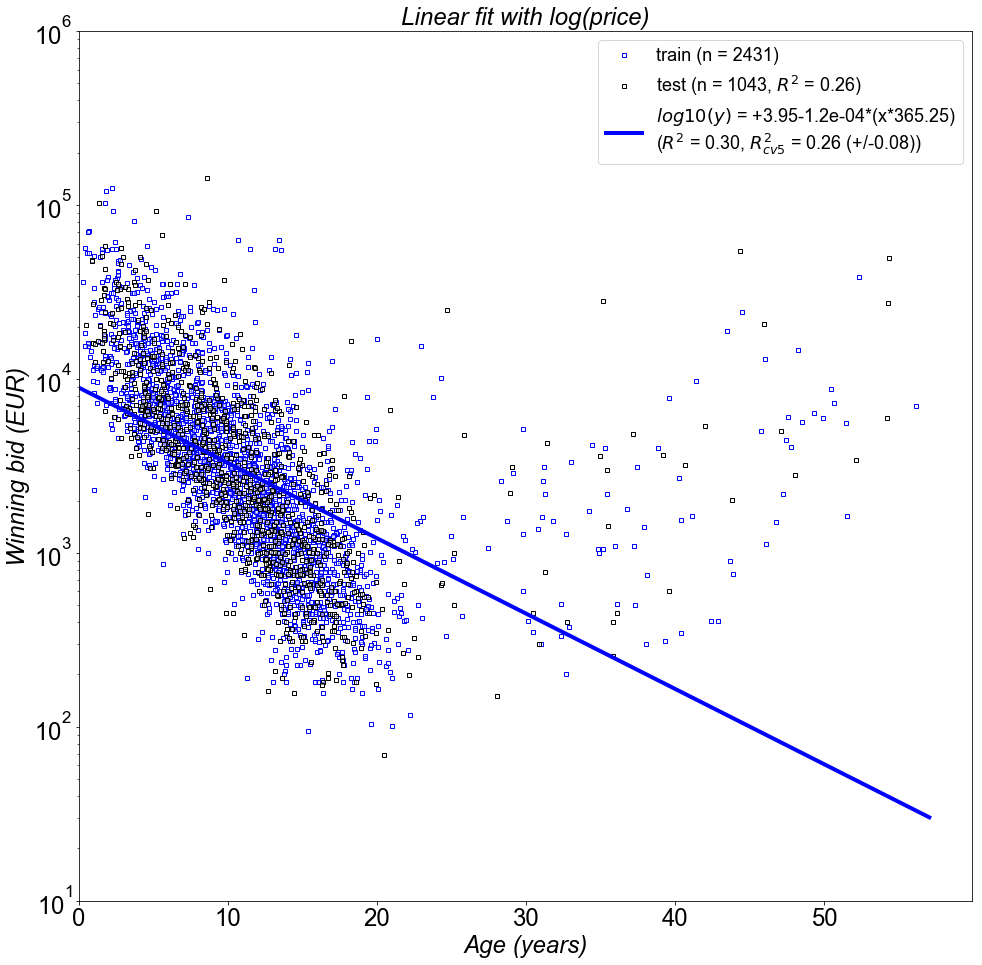

In [11]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
hdl_trn = plt.plot(X_train/365.25, pd.np.power(10,y_train), marker='s', markeredgecolor = (0, 0, 1, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='train (n = {})'.format(y_train.shape[0]))
hdl_tst = plt.plot(X_test/365.25, pd.np.power(10,y_test), marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='test (n = {}, $R^2$ = {:.2f})'.format(
                       y_test.shape[0],
                       models[model_name]['test R^2'],
                   ))
hdl_fit = plt.plot(prediction_X/365, pd.np.power(10,prediction_y), color='blue', marker=None, linestyle='-', linewidth=4, 
                   label = '$log10(y)$ = {:+.2f}{:+.1e}*(x*365.25)\n($R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f}))'.format(
                       *models[model_name]['betas'],
                       models[model_name]['R^2'],
                       models[model_name]['cv R^2'].shape[0],
                       pd.np.mean(models[model_name]['cv R^2']),
                       pd.np.std(models[model_name]['cv R^2']),
                   ))
plt.legend()
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR)', style='italic')
plt.title('Linear fit with log(price)', style='italic')
plt.ylim(bottom = 10, top = 1000000)
plt.xlim(left = 0)
plt.yscale('log')

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

## Model: scaled price, but only young cars

Same as model 2, but ignore cars older than 25y

## Prepare input

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score

model_name = 'linear regression log price young'

is_yng = df.age/365.25 < 25

X = df[is_yng].dropna(subset=['price','age']).age.values.reshape(-1,1)
y = pd.np.log10(df[is_yng].dropna(subset=['price','age']).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(3369, 1)
(3369, 1)


## Fit

In [13]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(2358, 1)
(1011, 1)


In [14]:
depr_half_n_days = -(pd.np.log10(2)/models[model_name]['betas'][1])
print('According to "{}"-model'.format(model_name))
print('Car depreciates to half its value every\n\t{:.0f} days ({:.1f} years).'.format(depr_half_n_days, depr_half_n_days/365.25))
for y in [0,2,4,6,8]:
    print('\ty(t={:+5.0f}) = {:.0f} euro'.format(y, 10**reg.predict([[y*365.25]])[0][0]))
print('\n\ty(t={:+5.1f}) = {:.0f} euro'.format(depr_half_n_days/365.25, 10**reg.predict([[depr_half_n_days]])[0][0]))
print('\ty(t=0) / 2 = {:.0f} euro'.format(10**models[model_name]['betas'][0]/2))

According to "linear regression log price young"-model
Car depreciates to half its value every
	1263 days (3.5 years).
	y(t=   +0) = 24215 euro
	y(t=   +2) = 16215 euro
	y(t=   +4) = 10858 euro
	y(t=   +6) = 7271 euro
	y(t=   +8) = 4869 euro

	y(t= +3.5) = 12108 euro
	y(t=0) / 2 = 12108 euro


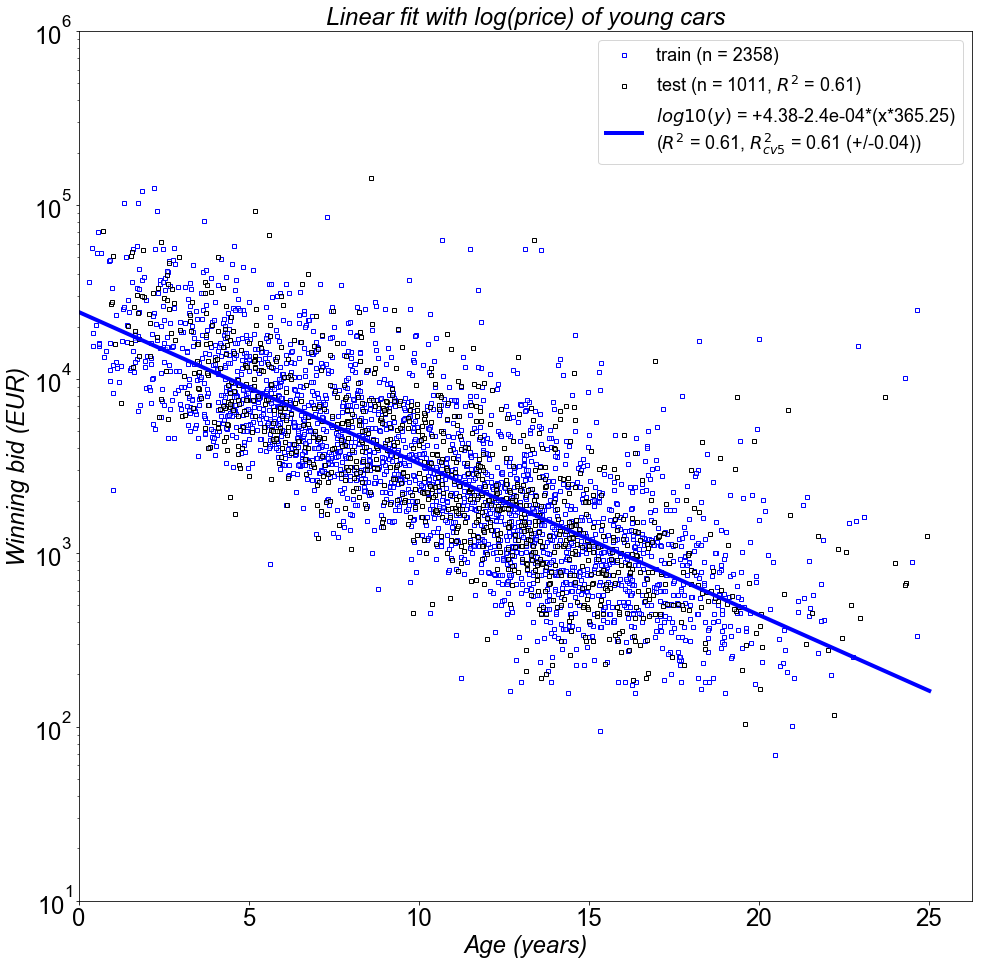

In [15]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
hdl_trn = plt.plot(X_train/365.25, pd.np.power(10,y_train), marker='s', markeredgecolor = (0, 0, 1, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='train (n = {})'.format(y_train.shape[0]))
hdl_tst = plt.plot(X_test/365.25, pd.np.power(10,y_test), marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='test (n = {}, $R^2$ = {:.2f})'.format(
                       y_test.shape[0],
                       models[model_name]['test R^2'],
                   ))
hdl_fit = plt.plot(prediction_X/365, pd.np.power(10,prediction_y), color='blue', marker=None, linestyle='-', linewidth=4, 
                   label = '$log10(y)$ = {:+.2f}{:+.1e}*(x*365.25)\n($R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f}))'.format(
                       *models[model_name]['betas'],
                       models[model_name]['R^2'],
                       models[model_name]['cv R^2'].shape[0],
                       pd.np.mean(models[model_name]['cv R^2']),
                       pd.np.std(models[model_name]['cv R^2']),
                   ))
plt.legend()
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR)', style='italic')
plt.title('Linear fit with log(price) of young cars', style='italic')
plt.ylim(bottom = 10, top = 1000000)
plt.xlim(left = 0)
plt.yscale('log')

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

- - - - - 
# Model: Multiple linear fit

Above models only used [Age] as predictor of price. MLR will regress many (numerical) features with price (euro).  


## Prepare input

In [16]:
model_name = 'MLR reduced observations'

features = num_columns 
# Can be reduced here

X = df.dropna(subset=['price'] + features).loc[:,features].values.reshape(-1,len(features))
y = pd.np.log10(df.dropna(subset=['price'] + features).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(915, 18)
(915, 1)


## Fit

In [17]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(640, 18)
(275, 18)


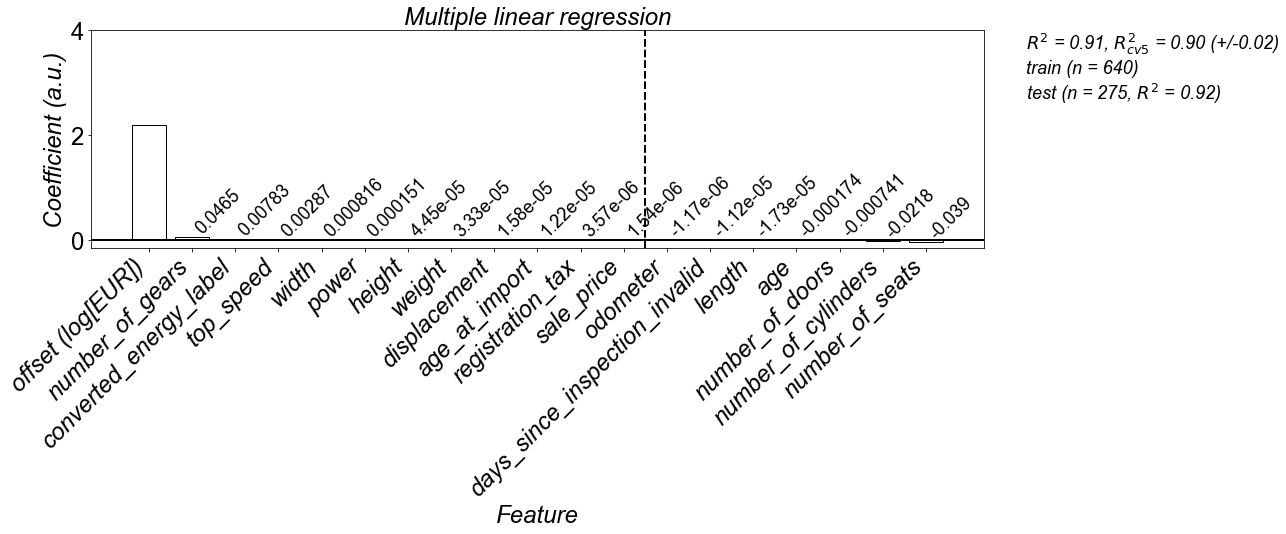

In [18]:
# plot coefficients
plt.figure(figsize=[16,4])

# sorted bar height
betas = models[model_name]['betas']
x = ['offset (log[EUR])'] + [features[i] for i in pd.np.argsort(betas[1:])[::-1]]
y = [betas[0]] + sorted(betas[1:], reverse=True)

# plot bar
plt.bar(x=x, height=y, edgecolor='k', facecolor='None')

# add values when bar is small
for x_val, coef in zip(x,y):
    if pd.np.abs(coef)<1:
        plt.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
plt.yticks(range(0,5,2))

# plot origin
x_sign_switch = pd.np.nonzero(pd.np.array(y) < 0)[0][0]
plt.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
plt.axhline(0, linewidth=2, linestyle='-', color='k')
        
x_sign_switch = pd.np.nonzero(pd.np.array(y) < 0)[0][0]
yl = plt.gca().get_ylim()
plt.vlines(x_sign_switch-0.5, yl[0], yl[1], linewidth=2, linestyle='--')
plt.gca().set_ylim(yl)
# plt.gca().set_ylim(top=0.01, bottom=-0.01)

# labels        
plt.gca().set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')
plt.xlabel('Feature', style='italic')
plt.ylabel('Coefficient (a.u.)', style='italic')
plt.title('Multiple linear regression', style='italic') 

# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    pd.np.mean(models[model_name]['cv R^2']),
    pd.np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')


plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

- - - - - 
# Model: MLR + imputer

MLR as above, but instead of `dropna` us an imputer. This allows to use more obeservation. Also at this point a pipeline is used.

## Prepare input

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model_name = 'MLR impute median'

features = num_columns 
# Can be reduced here

yX = df.loc[:,['price'] + features].dropna(subset=['price'])
X = yX.iloc[:,1:].values.reshape(-1,len(features))
y = pd.np.log10(yX.iloc[:,0].values.reshape(-1,1))
print(X.shape)
print(y.shape)

(3482, 18)
(3482, 1)


## Fit

In [20]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
pl = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    linear_model.LinearRegression()
)
models[model_name].update({'model':pl})

# fit
pl.fit(X,y)
models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [*pl.steps[-1][1].intercept_, *pl.steps[-1][1].coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':pl.score(X,y)})
models[model_name].update({'test R^2':pl.score(X_test,y_test)})
cv_results = cross_val_score(pl, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(2437, 18)
(1045, 18)


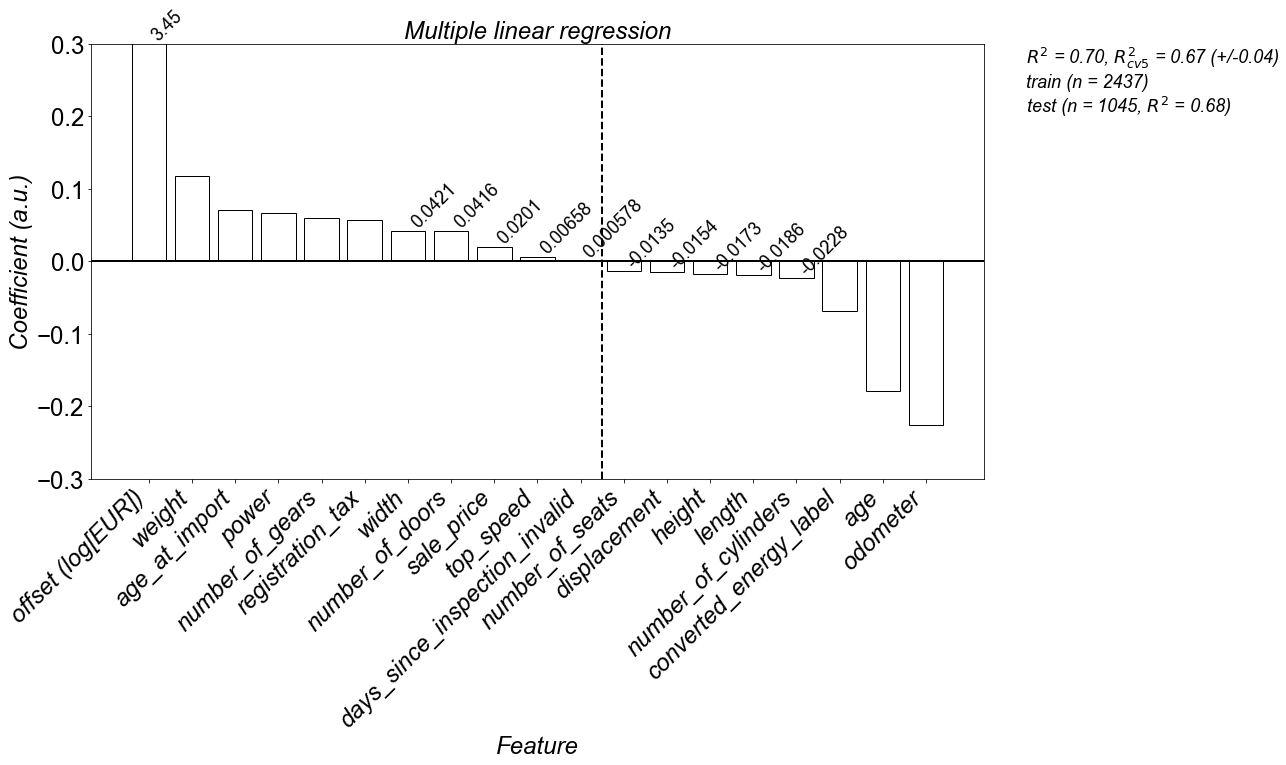

In [21]:
# plot coefficients
plt.figure(figsize=[16,8])

# sorted bar height
betas = models[model_name]['betas']
x = ['offset (log[EUR])'] + [features[i] for i in pd.np.argsort(betas[1:])[::-1]]
y = [betas[0]] + sorted(betas[1:], reverse=True)

# plot bar
plt.bar(x=x, height=y, edgecolor='k', facecolor='None')

# add values when bar is small
for x_val, coef in zip(x,y):
    if pd.np.abs(coef)<0.05:
        plt.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
plt.yticks(pd.np.arange(-0.3,0.4,0.1))
plt.ylim(top=+0.3, bottom=-0.3)
# offset
x_val = x[0]
coef = y[0]
plt.text(x_val, 0.3, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')

# plot origin
x_sign_switch = pd.np.nonzero(pd.np.array(y) < 0)[0][0]
plt.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
plt.axhline(0, linewidth=2, linestyle='-', color='k')

# labels        
plt.gca().set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')
plt.xlabel('Feature', style='italic')
plt.ylabel('Coefficient (a.u.)', style='italic')
plt.title('Multiple linear regression', style='italic') 

# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    pd.np.mean(models[model_name]['cv R^2']),
    pd.np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')


plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

- - - - - 
# Model: MLR with categorical

As MLR, but do one-hot-encoding

Use different scalers for different columns:  
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html  
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
p. 68 book: ML with sklearn & tf

## Prepare input

In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import FeatureUnion

model_name = 'MLR with categorical'

cat_columns_reduced = list(pd.np.setdiff1d(cat_columns, ['model', 'fuel']))
features = num_columns + cat_columns_reduced
# Can be reduced here

# list of lists with categories. Needed for column transformer
cats = list(df[cat_columns_reduced].apply(lambda x:pd.Series(x.unique()).dropna().tolist() + ['missing'], axis='index'))

# Use data frame not array
yX = df.dropna(subset=['price'])
# # only use young
# is_yng = yX.age/365.25 < 25
# yX = yX[is_yng]
X = yX.iloc[:,1:]
y = yX.iloc[:,0]
print(X.shape)
print(y.shape)


(3482, 25)
(3482,)


In [23]:
import re

# Split fuel helper functions

def split_lpg_type(s):
    '''Split lpg type from list of fuels separated by / '''
    # No type
    if s.endswith('lpg'):
        return s, ''
    if 'lpg' not in s:
        return s, ''
    # Type is after the last '/'
    M = re.search('^(.*)/(.*)$',s)
    if M:
        return M[1], M[2]
    else:
        return s, ''

def merge_lpg_and_lpgtype(fuel_type):

    '''Add LPG type to LPG (remove /). 
    Note that order of fuels is preserved. I.e. it is able to return both "benzine/lpg-g3" and "lpg-g3/benzine". '''
    
    lpg_type = fuel_type.apply(lambda s: 'lpg-' + split_lpg_type(s)[1] if (type(s) == str) and ('lpg' in s) else '')
    fuel_type_short = fuel_type.apply(lambda s: split_lpg_type(s)[0] if (type(s) == str) else '')
    fuel_type_new = pd.Series([f.replace('lpg', l) if type(f) == str else f for f,l in zip(fuel_type_short,lpg_type)])
    return fuel_type_new


def get_unique_fuels(fuel_type):
    
    '''Splitting fuels at "/" and return unique values'''
    
    # make list (as string)
    fuel_type_list = fuel_type.apply(lambda s:s.split('/') if type(s) == str else pd.np.NaN).astype(str)
    
    # Get unique fuels
    possible_fuels = list() # empty list
    for l in fuel_type_list.unique():
        for ll in eval(l): # use eval to convert str to list
            possible_fuels += [ll]     
    # uniquify
    return pd.np.unique(possible_fuels)

    
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to make one-hot fuel encoder based on string
# This is different from get_dummies, because it can take a list of values in a field
class DummyfyFuel(BaseEstimator, TransformerMixin):
    def __init__(self, fuel_names=None):
        
        assert (fuel_names == None) or (isinstance(fuel_names, (list,))), '[fuel_names] should be list (or None)'
        
        self.fuel_names = fuel_names
        
    def fit(self, X, y=None):
        
        if not self.fuel_names:
            # get fuel names based on input.
            # Note that if train/test are split, test might lack a fuel type.
            self.fuel_names = get_unique_fuels(merge_lpg_and_lpgtype(X))

        return self
    
    def transform(self, X):
        
        # get stringyfied list
        fuel_type_list = merge_lpg_and_lpgtype(X).apply(lambda s:s.split('/') if type(s) == str else pd.np.NaN).astype(str)
        # set index as input
        fuel_type_list.index = X.index

        # transform: dummies
        fuel_dummies = pd.DataFrame(index=fuel_type_list.index)
        for f in self.fuel_names:
            fuel_dummies['fuel_' + f] = fuel_type_list.apply(lambda l:int(f in eval(l)))

        return fuel_dummies


In [24]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)


(2437, 25)
(1045, 25)


In [25]:
# Create model

# Preprocessor: numerical features
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
)
# Preprocessor: categorical features
cat_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing', missing_values=pd.np.NaN),
    OneHotEncoder(categories=cats),
)

# Preprocess: fuels
# list of all fuels is passed by using full data set! (X)
fuel_list = list(get_unique_fuels(merge_lpg_and_lpgtype(X.fuel)))
#fuel_list = ['benzine', 'diesel']
get_fuel_dummies = DummyfyFuel(fuel_list)


# Combine num and cat
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, num_columns),
    ('categorical', cat_transformer, cat_columns_reduced),
    ('onehot_fuel', get_fuel_dummies, 'fuel')
], verbose=True)

# full pipeline with preproc and mlr
mlr = make_pipeline(
    preprocessor,
    linear_model.LinearRegression()
)

# Target transformation: log transform price
pl = TransformedTargetRegressor(
    regressor=mlr,
    func=pd.np.log10,
    inverse_func=lambda y: 10**y
#     func=lambda x:x,
#     inverse_func=lambda y: y
)

models[model_name].update({'model':pl})

In [26]:
# fit
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)

# sanity check that target transformation has occured as expected
# y_pred_manual_transform = mlr.predict(X_test)
# assert all(pd.np.log10(y_pred)-y_pred_manual_transform == 0)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [pl.regressor_.steps[-1][1].intercept_, *pl.regressor_.steps[-1][1].coef_]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':pl.score(X,y)})
models[model_name].update({'test R^2':pl.score(X_test,y_test)})
cv_results = cross_val_score(pl, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})



[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.3s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[Colum

In [27]:
# update features, by adding fuels
cat_columns_reduced += ['fuel']
cats += [fuel_list]


In [28]:
# Split betas per category feature.
idx_start = len(num_columns)+1
cat_betas = list()
for cat in cats:
    cat_betas += [betas[idx_start:idx_start+len(cat)]]
    idx_start += len(cat)
# Check if all betas are stored
assert cat_betas[0][0] == betas[len(num_columns)+1] # first
assert cat_betas[-1][-1] == betas[-1] # last

Text(0.5, 0, 'Sorted features')

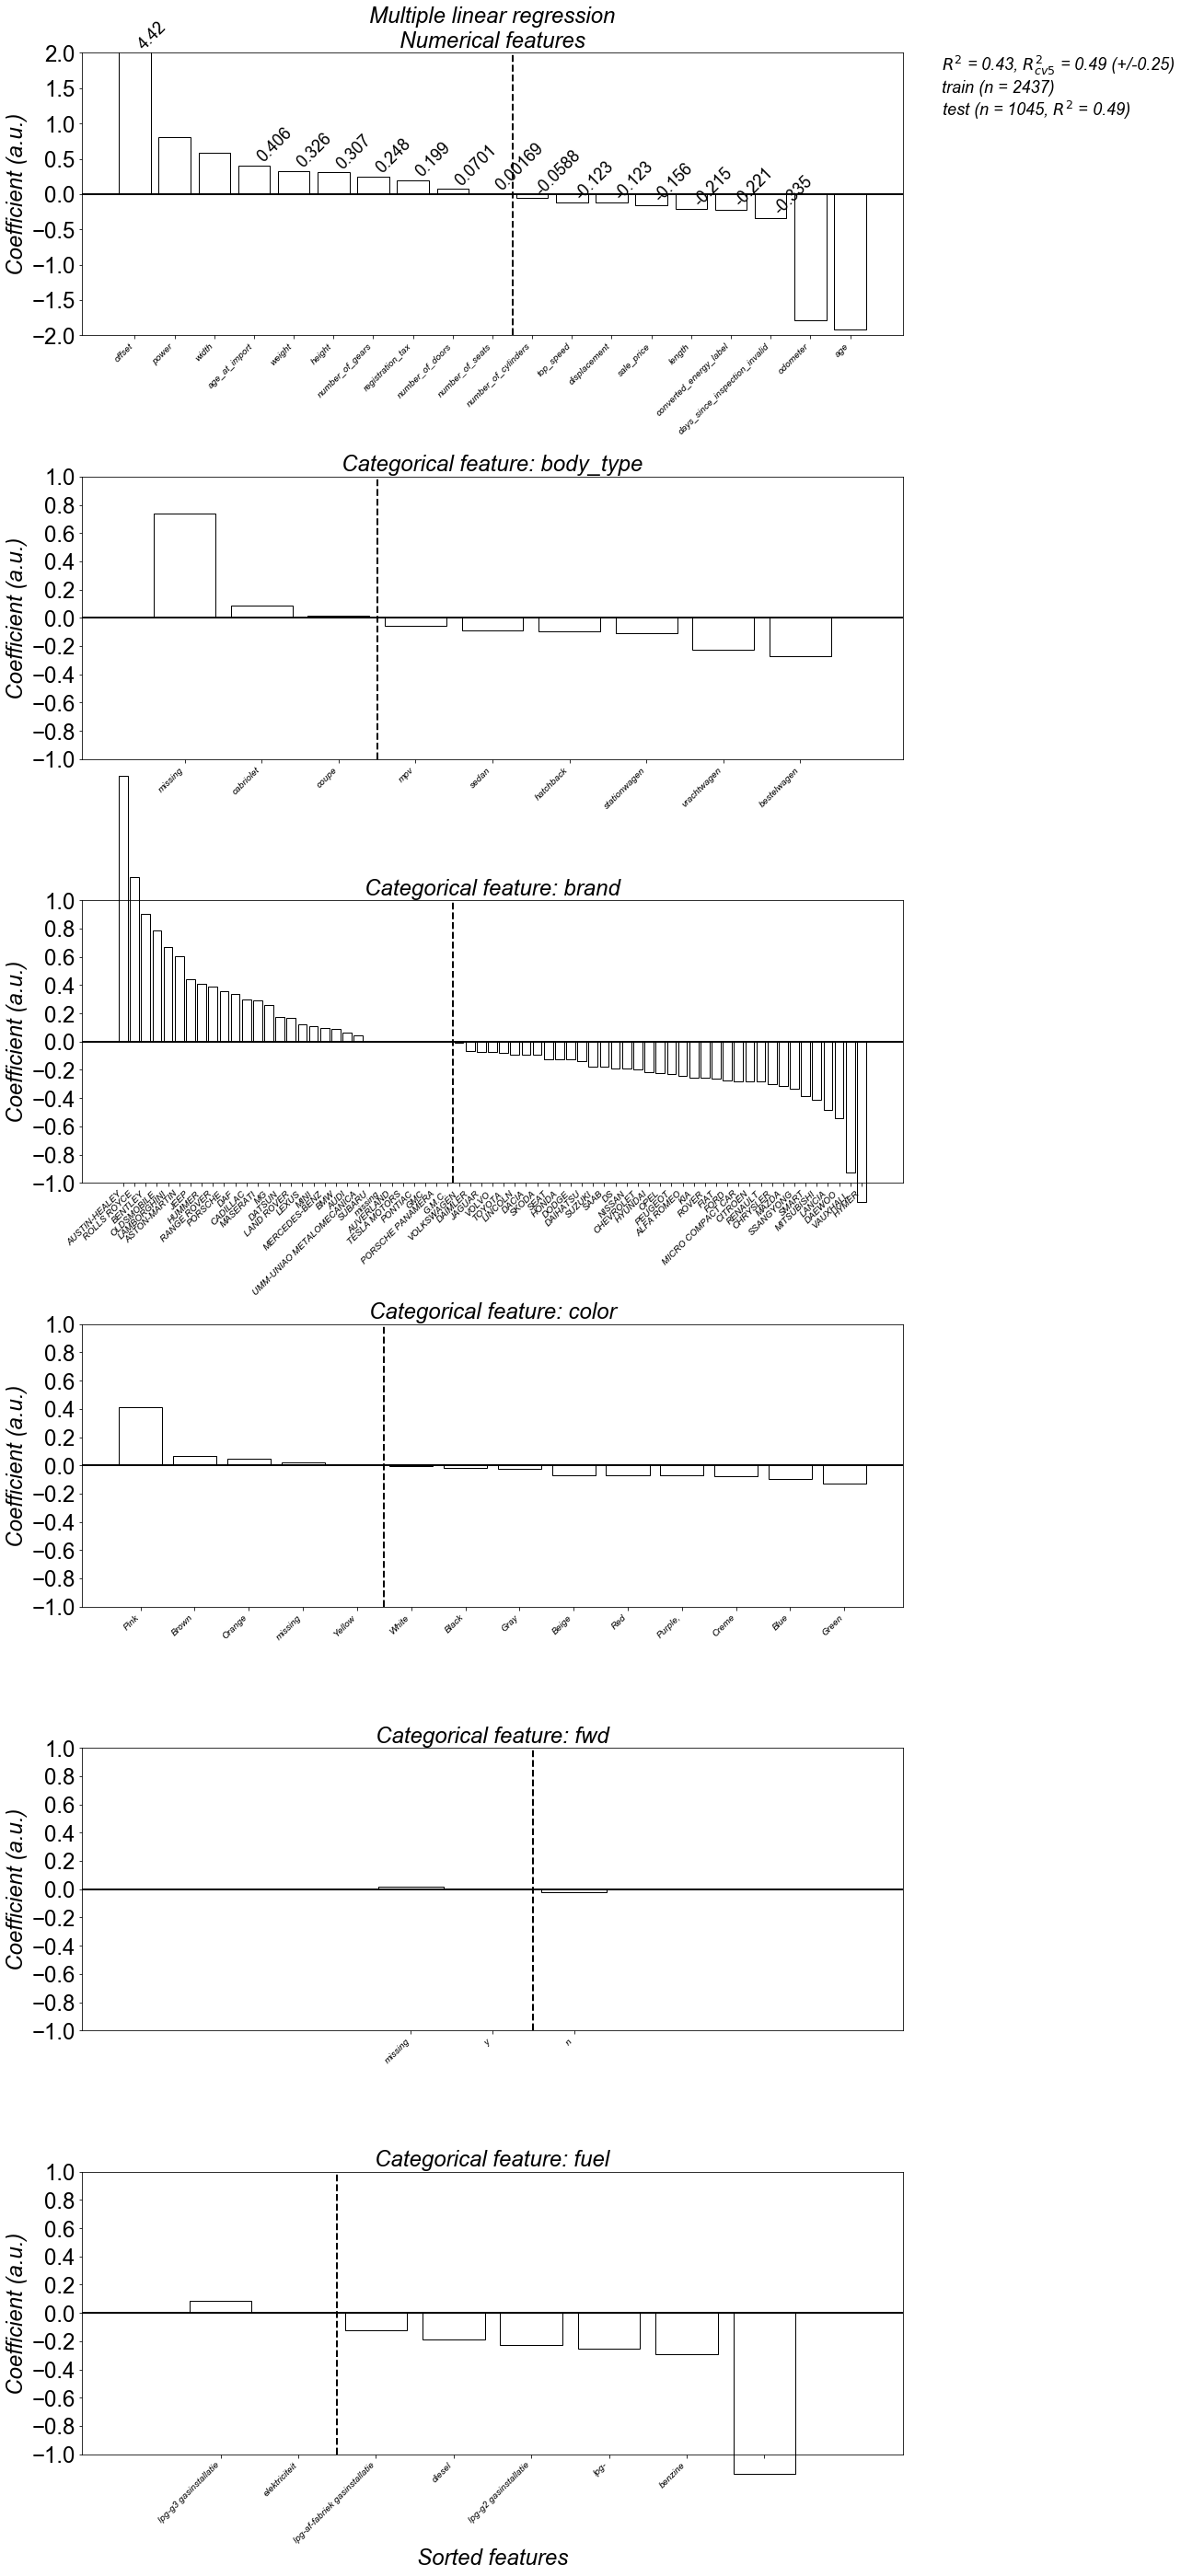

In [29]:
# plot coefficients

# plot numerical and catagorical in different subplots
n_plots = len(cat_columns_reduced) + 1
fig,axs=plt.subplots(
    nrows=n_plots,
    figsize=[16,8*n_plots]
)
plt.subplots_adjust(hspace=0.5)


# Plot numerical
plt.sca(axs[0])
# sorted bar height
betas = models[model_name]['betas']
num_betas = betas[1:len(num_columns)+1]
x = ['offset'] + [features[i] for i in pd.np.argsort(num_betas)[::-1]]
y = [betas[0]] + sorted(num_betas, reverse=True)

# plot bar
plt.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=True)

# add values when bar is small
for x_val, coef in zip(x,y):
    if pd.np.abs(coef)<0.5:
        plt.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
plt.yticks(pd.np.arange(-2,2.2,0.5))
plt.ylim(top=+2, bottom=-2)
# offset
x_val = x[0]
coef = y[0]
plt.text(x_val, 2, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')

# plot origin
x_sign_switch = pd.np.nonzero(pd.np.array(y) < 0)[0][0]
plt.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
plt.axhline(0, linewidth=2, linestyle='-', color='k')

# labels        
rot = 45
fsz = 10
ha = 'right'
plt.gca().set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
plt.ylabel('Coefficient (a.u.)', style='italic')
plt.title('Multiple linear regression\nNumerical features', style='italic') 

# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    pd.np.mean(models[model_name]['cv R^2']),
    pd.np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')

# Plot categorical
for cat, cat_beta, cat_name, ax in zip(cats, cat_betas, cat_columns_reduced, axs[1:]):
    # activate subplot axes
    plt.sca(ax)
    # sort by height
    x = [cat[i] for i in pd.np.argsort(cat_beta)[::-1]]
    y = sorted(cat_beta, reverse=True)
    #x = cat
    #y = cat_beta
    # plot bar
    plt.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=False)

    # prettify
    plt.yticks(pd.np.arange(-1,+1.1,0.2))
    plt.ylim(top=+1, bottom=-1)

    # plot origin
    x_sign_switch = pd.np.nonzero(pd.np.array(y) < 0)[0][0]
    plt.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
    plt.axhline(0, linewidth=2, linestyle='-', color='k')

    # labels
    rot = 45
    fsz = 10
    ha = 'right'
    ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
    plt.title('Categorical feature: ' + cat_name, style='italic')
    plt.ylabel('Coefficient (a.u.)', style='italic')
    # add extra margin if bars are too wide (too little bars)
    if len(x) < 10:
        add_space = len(x) - 10
        xl = list(plt.xlim())
        xl[1] -= add_space/2
        xl[0] += add_space/2
        plt.xlim(xl)

# Label on bottom panel
plt.sca(axs[-1])
plt.xlabel('Sorted features', style='italic')

# Save
# plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)


- - - - - 

,2018-11-8326,2017-7-2209,2019-5-8204,2017-10-7134,2018-9-8108,2018-12-2005,2017-11-2215,2018-4-7110,2018-5-8195,2019-7-7240,2018-12-7207,2018-7-2415,2018-3-8191,2017-7-8101,2017-12-2216,2018-12-7174
brand,UMM-UNIAO METALOMECANICA,CADILLAC,MICRO COMPACT CAR,DATSUN,CHEVROLET,MERCEDES-BENZ,HUMMER,LINCOLN,DAIMLER,DS,VAUXHALL,AUSTIN-HEALEY,MERCEDES-BENZ,LANCIA,HYMER,MERCEDES-BENZ
model,jeep,escalade,smart,280 zx 2+2,spark,e 200 cabriolet,H2,continental mark III,sovereign 4.2 l,3,zafira design c,3000 mkiii phase ii,c 180,ypsilon,ex 524,c 160
age,11627,4105,6937,12877,2296,8663,3702,17442,14692,591,4474,19116,6194,4209,1351,4617
fuel,NaN,lpg/g2 gasinstallatie,benzine,benzine,lpg/benzine/af-fabriek gasinstallatie,benzine,NaN,lpg/g2 gasinstallatie,benzine,diesel,NaN,benzine,benzine,benzine,diesel,benzine
odometer,9971,368782,149939,179061,66644,118050,108028,71397,31434,25400,166495,106801,178527,145596,19318,196132
days_since_inspection_invalid,NaN,-73,179,388,10,824,NaN,-60,1119,-505,NaN,-402,NaN,-747,-609,112
age_at_import,NaN,0,0,461,0,373,NaN,10546,0,449,NaN,18063,0,2941,535,0
body_type,NaN,vrachtwagen,hatchback,NaN,hatchback,cabriolet,NaN,NaN,NaN,hatchback,NaN,cabriolet,sedan,hatchback,NaN,coupe
displacement,NaN,5967,599,NaN,995,1998,NaN,NaN,NaN,1560,NaN,2912,1998,1242,2287,1796
number_of_cylinders,NaN,8,3,6,4,4,NaN,8,6,4,NaN,6,4,4,4,4


,2018-1-3065,2019-3-8189,2019-3-8201,2017-6-2200,2017-11-2402,2018-1-2615,2019-2-7260,2017-3-2003,2019-8-2221,2017-3-2007,2019-4-2021,2017-3-2409,2017-5-2216,2018-1-2412,2017-3-2000,2018-7-2411
brand,MERCEDES-BENZ,VOLKSWAGEN,VOLKSWAGEN,CHEVROLET,JAGUAR,FIAT,OPEL,VOLKSWAGEN,ALFA ROMEO,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN,ALFA ROMEO,VOLKSWAGEN,ALFA ROMEO,MERCEDES-BENZ
model,290 gdt,polo,polo,camaro sport coupe,xj-s 4.0 e2,x 1/9,ascona 1.6s,152131,giulia 1300 super,karmann ghia,111011,T2,2000 gtv,t1,2000 gtv,sl230
age,7305,6456,7476,16773,8881,13569,11956,15121,17379,18507,19787,15873,16257,19813,16196,19848
fuel,NaN,NaN,benzine,benzine,benzine,benzine,benzine,NaN,NaN,NaN,benzine,NaN,benzine,NaN,benzine,NaN
odometer,NaN,130082,NaN,9137,271353,35151,3314,84145,9050,59227,91157,46642,23982,96563.9,23982,68722
days_since_inspection_invalid,NaN,NaN,336,-278,572,NaN,66,NaN,NaN,NaN,1099,NaN,-739,NaN,-800,NaN
age_at_import,NaN,NaN,0,1261,0,0,0,NaN,NaN,NaN,16180,NaN,0,NaN,0,NaN
body_type,NaN,NaN,hatchback,NaN,coupe,cabriolet,NaN,NaN,NaN,NaN,sedan,NaN,coupe,NaN,coupe,NaN
displacement,NaN,NaN,1390,NaN,3980,1498,NaN,NaN,NaN,NaN,1192,NaN,NaN,NaN,NaN,NaN
number_of_cylinders,NaN,NaN,4,8,6,4,4,NaN,NaN,NaN,4,NaN,4,NaN,4,NaN


,2019-4-2411,2018-6-2410,2017-5-2406,2018-8-2410,2017-3-2000,2018-7-2411,2017-8-2409,2018-6-2408,2017-9-2408,2018-9-2400,2017-4-2400,2017-12-2404,2019-3-2410,2019-8-2415,2019-6-2413,2017-6-2409
brand,MERCEDES-BENZ,MERCEDES-BENZ,MERCEDES-BENZ,ASTON-MARTIN,ALFA ROMEO,MERCEDES-BENZ,PORSCHE,AUDI,MERCEDES-BENZ,MERCEDES-BENZ,JAGUAR,LAND ROVER,NISSAN,LAMBORGHINI,BMW,JAGUAR
model,amg s63 cabriolet,S65 AMG,S600 Maybach,dbs,2000 gtv,sl230,911 carrera s,rs6 avant,c-klasse 63 s AMG *,e63,f-pace,range rover,gtr,gallardo,m4,f-pace
age,636,844,810,2665,16196,19848,2039,1663,813,1523,138,1644,3542,4960,1871,199
fuel,NaN,NaN,benzine,NaN,benzine,NaN,NaN,NaN,NaN,NaN,diesel,NaN,NaN,NaN,NaN,diesel
odometer,13,6379,19173,58429,23982,68722,59807,37397,15636,59359,52000,74279,49583,26380,21848,52
days_since_inspection_invalid,NaN,NaN,-651,NaN,-800,NaN,NaN,NaN,NaN,NaN,-957,NaN,NaN,NaN,NaN,-896
age_at_import,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
body_type,NaN,NaN,sedan,NaN,coupe,NaN,NaN,NaN,NaN,NaN,stationwagen,NaN,NaN,NaN,NaN,stationwagen
displacement,NaN,NaN,5980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999,NaN,NaN,NaN,NaN,1999
number_of_cylinders,NaN,NaN,12,NaN,4,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,4


,2019-6-2611,2018-2-2408,2018-1-2411,2017-11-2411,2017-5-2401,2017-8-2406,2018-5-2401,2019-6-2206,2019-1-2218,2017-7-2402,2018-5-2402,2017-3-2405,2017-4-2404,2019-5-2405,2017-3-2400,2018-11-2401
brand,BMW,LAND ROVER,BMW,ASTON-MARTIN,BMW,MERCEDES-BENZ,LAND ROVER,BMW,JEEP,MERCEDES-BENZ,BMW,MERCEDES-BENZ,LAMBORGHINI,LAMBORGHINI,ASTON-MARTIN,BENTLEY
model,5er reihe,range rover evoque,x5 m50d,a-v12 vanquish,x6 m50d,glc 250 d 4matic,range rover evoque,5er reihe,renegade,gle 250 d 4matic,x6 xdrive40d,amg gle 63 s,gallardo,gallardo,rapide s,continental gtc
age,4714,701,1761,4893,1693,242,677,4422,1092,366,573,484,4797,3898,673,4200
fuel,benzine,diesel,diesel,benzine,diesel,diesel,diesel,benzine,benzine,diesel,diesel,benzine,benzine,benzine,benzine,benzine
odometer,244375,28223,36340,50826,60719,4006,26110,NaN,21885,14767,13744,20757,35410,25128,14415,27184
days_since_inspection_invalid,30,-394,-102,150,-748,-853,-418,160,-369,-729,-522,-977,-483,-287,-788,-21
age_at_import,1910,492,1349,1254,780,0,0,1124,0,0,0,135,0,3102,297,2028
body_type,NaN,stationwagen,stationwagen,coupe,stationwagen,hatchback,stationwagen,NaN,mpv,stationwagen,sedan,stationwagen,coupe,cabriolet,hatchback,cabriolet
displacement,4799,1999,2993,5935,2993,2143,1999,2996,1368,2143,2993,5461,4961,4961,5935,5998
number_of_cylinders,8,4,6,12,6,4,4,6,4,4,6,8,10,10,12,12


Text(0, 0.5, 'prediction error [log of fraction]\n(positive: prediction overestimates)')

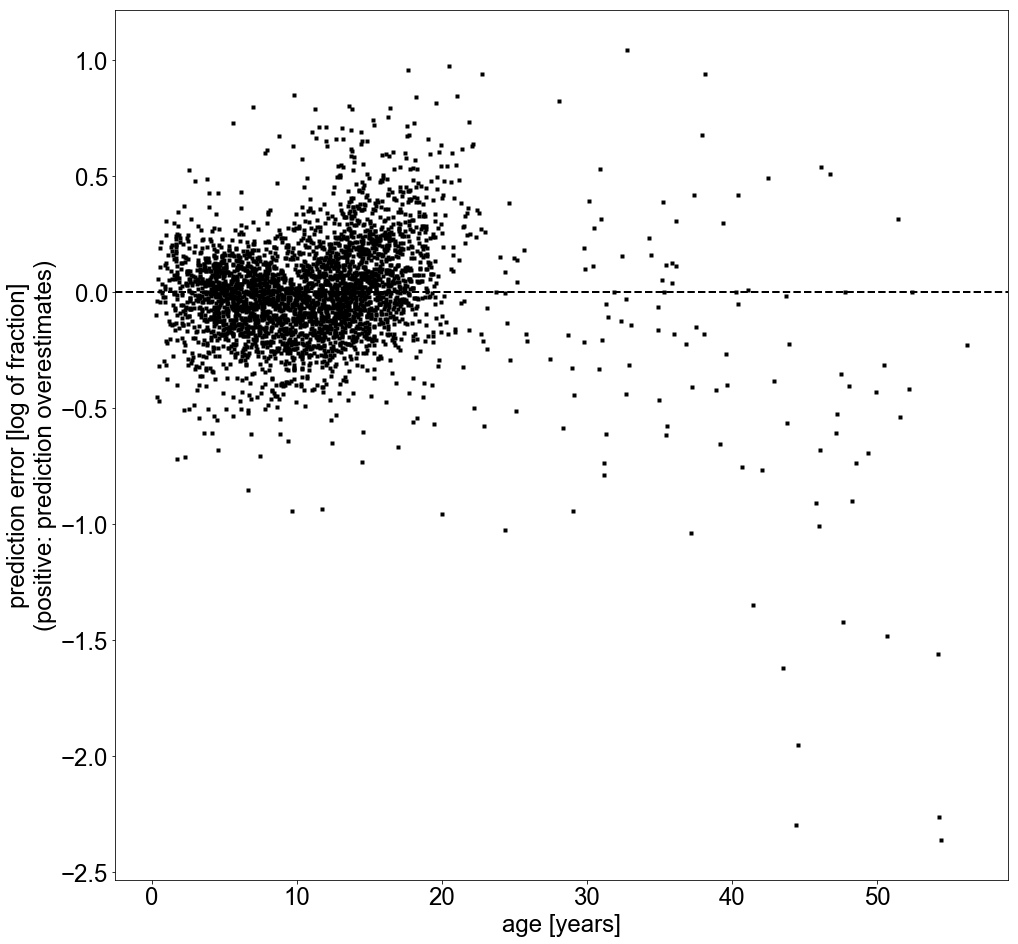

In [30]:
# Display prediction errors

x_sample = df.dropna(subset=['price']).iloc[:,1:]
y_sample = df.dropna(subset=['price']).iloc[:,0]
y_sample_pred = pl.predict(x_sample) 

x_sample['price'] = y_sample
x_sample['prediction_error'] = y_sample_pred - y_sample
x_sample['prediction_error_fraction'] = y_sample_pred/y_sample
x_sample['prediction_error_log'] = pd.np.log10(x_sample.prediction_error_fraction)
x_sample['prediction_error_abslog'] = pd.np.abs(pd.np.log10(x_sample.prediction_error_fraction))
x_sample['prediction'] = y_sample_pred
x_sample['age_y'] = x_sample.age/365

# Note some are close to perferct, because they are in training set and are unique in brand etc
display(x_sample.sort_values(by='prediction_error_abslog').head(16).T)
display(x_sample.sort_values(by='prediction_error_abslog').tail(16).T)
display(x_sample.sort_values(by='prediction_error').head(16).T)
display(x_sample.sort_values(by='prediction_error').tail(16).T)

plt.figure(figsize=[16,16])
plt.plot(x_sample.age_y, x_sample.prediction_error_log, color='k', marker='s', markeredgecolor = (0, 0, 0, 0), markerfacecolor = (0, 0, 0, 1), linestyle='None', ms=4)
plt.axhline(0, lw=2, linestyle='--', color ='k')
plt.xlabel('age [years]')
plt.ylabel('prediction error [log of fraction]\n(positive: prediction overestimates)')

- - - - - 
# Model: MLR regularized

As model 5, but use regularization by using built-in Lasso

## Prepare input

In [31]:
from sklearn.model_selection import GridSearchCV

model_name = 'MLR Lasso'

cat_columns_reduced = list(pd.np.setdiff1d(cat_columns, ['model', 'fuel']))
features = num_columns + cat_columns_reduced
# Can be reduced here

# list of lists with categories. Needed for column transformer
cats = list(df[cat_columns_reduced].apply(lambda x:pd.Series(x.unique()).dropna().tolist() + ['missing'], axis='index'))

# Use data frame not array
yX = df.dropna(subset=['price'])
X = yX.iloc[:,1:]
y = yX.iloc[:,0]
print(X.shape)
print(y.shape)


(3482, 25)
(3482,)


## Determine regularization rate (alpha)

Alpha is the hyperparameter that needs to be determined. For this the data needs to be splitted, but the dataset is too small to do a 3 way split (i.e. CV, Train, Test). Therefor spilt 2 way k-fold cv 
- **Test**: Hold-out set for calculating performance
- **Train**: Use to fit model and do CV


In [32]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)


(2437, 25)
(1045, 25)


In [33]:
# Create model (same as MLR with cats, but regressor is Lasso)

# Preprocessor: numerical features
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
)
# Preprocessor: categorical features
cat_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing', missing_values=pd.np.NaN),
    OneHotEncoder(categories=cats),
)

# Preprocess: fuels
# list of all fuels is passed by using full data set! (X)
fuel_list = list(get_unique_fuels(merge_lpg_and_lpgtype(X.fuel)))
get_fuel_dummies = DummyfyFuel(fuel_list)


# Combine num and cat
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, num_columns),
    ('categorical', cat_transformer, cat_columns_reduced),
    ('onehot_fuel', get_fuel_dummies, 'fuel')
], verbose=True)

# full pipeline with preproc and mlr
mlr = make_pipeline(
    preprocessor,
    linear_model.Lasso(random_state=42)
)

# Target transformation: log transform price
pl = TransformedTargetRegressor(
    regressor=mlr,
    func=pd.np.log10,
    inverse_func=lambda y: 10**y
)



In [34]:
# grid search estimator
grid_search_alpha = GridSearchCV(
    estimator=pl,
    param_grid=[
        {
            'regressor__lasso__alpha': 10**(pd.np.linspace(-4,-1,13))
        } 
    ],
    cv=8,
    scoring='r2',
    n_jobs=4,
    verbose=10
)

# Perform grid search
grid_search_alpha.fit(X_train,y_train)

Fitting 8 folds for each of 13 candidates, totalling 104 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   24.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   30.8s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:   34.0s finished
/Users/Tom/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will chang

[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.5s


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=TransformedTargetRegressor(check_inverse=True,
                                                  func=<ufunc 'log10'>,
                                                  inverse_func=<function <lambda> at 0x1a1857cd08>,
                                                  regressor=Pipeline(memory=None,
                                                                     steps=[('columntransformer',
                                                                             ColumnTransformer(n_jobs=None,
                                                                                               remainder='drop',
                                                                                               sparse_threshold=0.3,
                                                                                               transformer_weights=None,
                                                                   

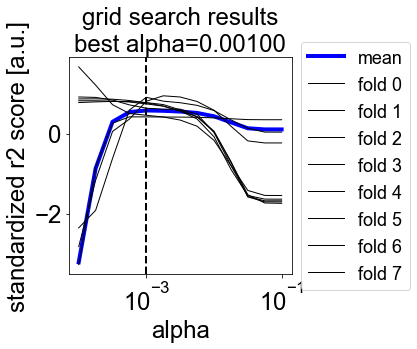

In [35]:
# plot search results
plt.figure(figsize=[4,4])

# abscissa
alphas = list(grid_search_alpha.cv_results_['param_regressor__lasso__alpha'])

# plot mean
r2_mean = grid_search_alpha.cv_results_['mean_test_score']
# normalize
r2_mean = (r2_mean-r2_mean.mean())/r2_mean.std()
plt.plot(alphas, r2_mean, label='mean', lw=4, color='blue')

# plot folds
for fold in range(grid_search_alpha.cv):
    r2_fold = grid_search_alpha.cv_results_['split{:.0f}_test_score'.format(fold)]
    # normalize
    r2_fold = (r2_fold-r2_fold.mean())/r2_fold.std()
    plt.plot(alphas, r2_fold, label='fold ' + str(fold), lw=1, color='black')

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('standardized r2 score [a.u.]')
plt.axvline(grid_search_alpha.best_params_['regressor__lasso__alpha'], linewidth=2, linestyle='--', color='k')
plt.title('grid search results\nbest alpha={:.5f}'.format(grid_search_alpha.best_params_['regressor__lasso__alpha']))
plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1,0.5))


### Fit with regressor found with grid search

In [36]:
# Store estimator with best alpha
reg = grid_search_alpha.best_estimator_
models[model_name].update({'model':reg})

# fit
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [reg.regressor_.steps[-1][1].intercept_, *reg.regressor_.steps[-1][1].coef_]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})

[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.4s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.2s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[Colum

In [37]:
# update features, by adding fuels
cat_columns_reduced += ['fuel']
cats += [fuel_list]

# Split betas per category feature.
idx_start = len(num_columns)+1
cat_betas = list()
for cat in cats:
    cat_betas += [betas[idx_start:idx_start+len(cat)]]
    idx_start += len(cat)
# Check if all betas are stored
assert cat_betas[0][0] == betas[len(num_columns)+1] # first
assert cat_betas[-1][-1] == betas[-1] # last

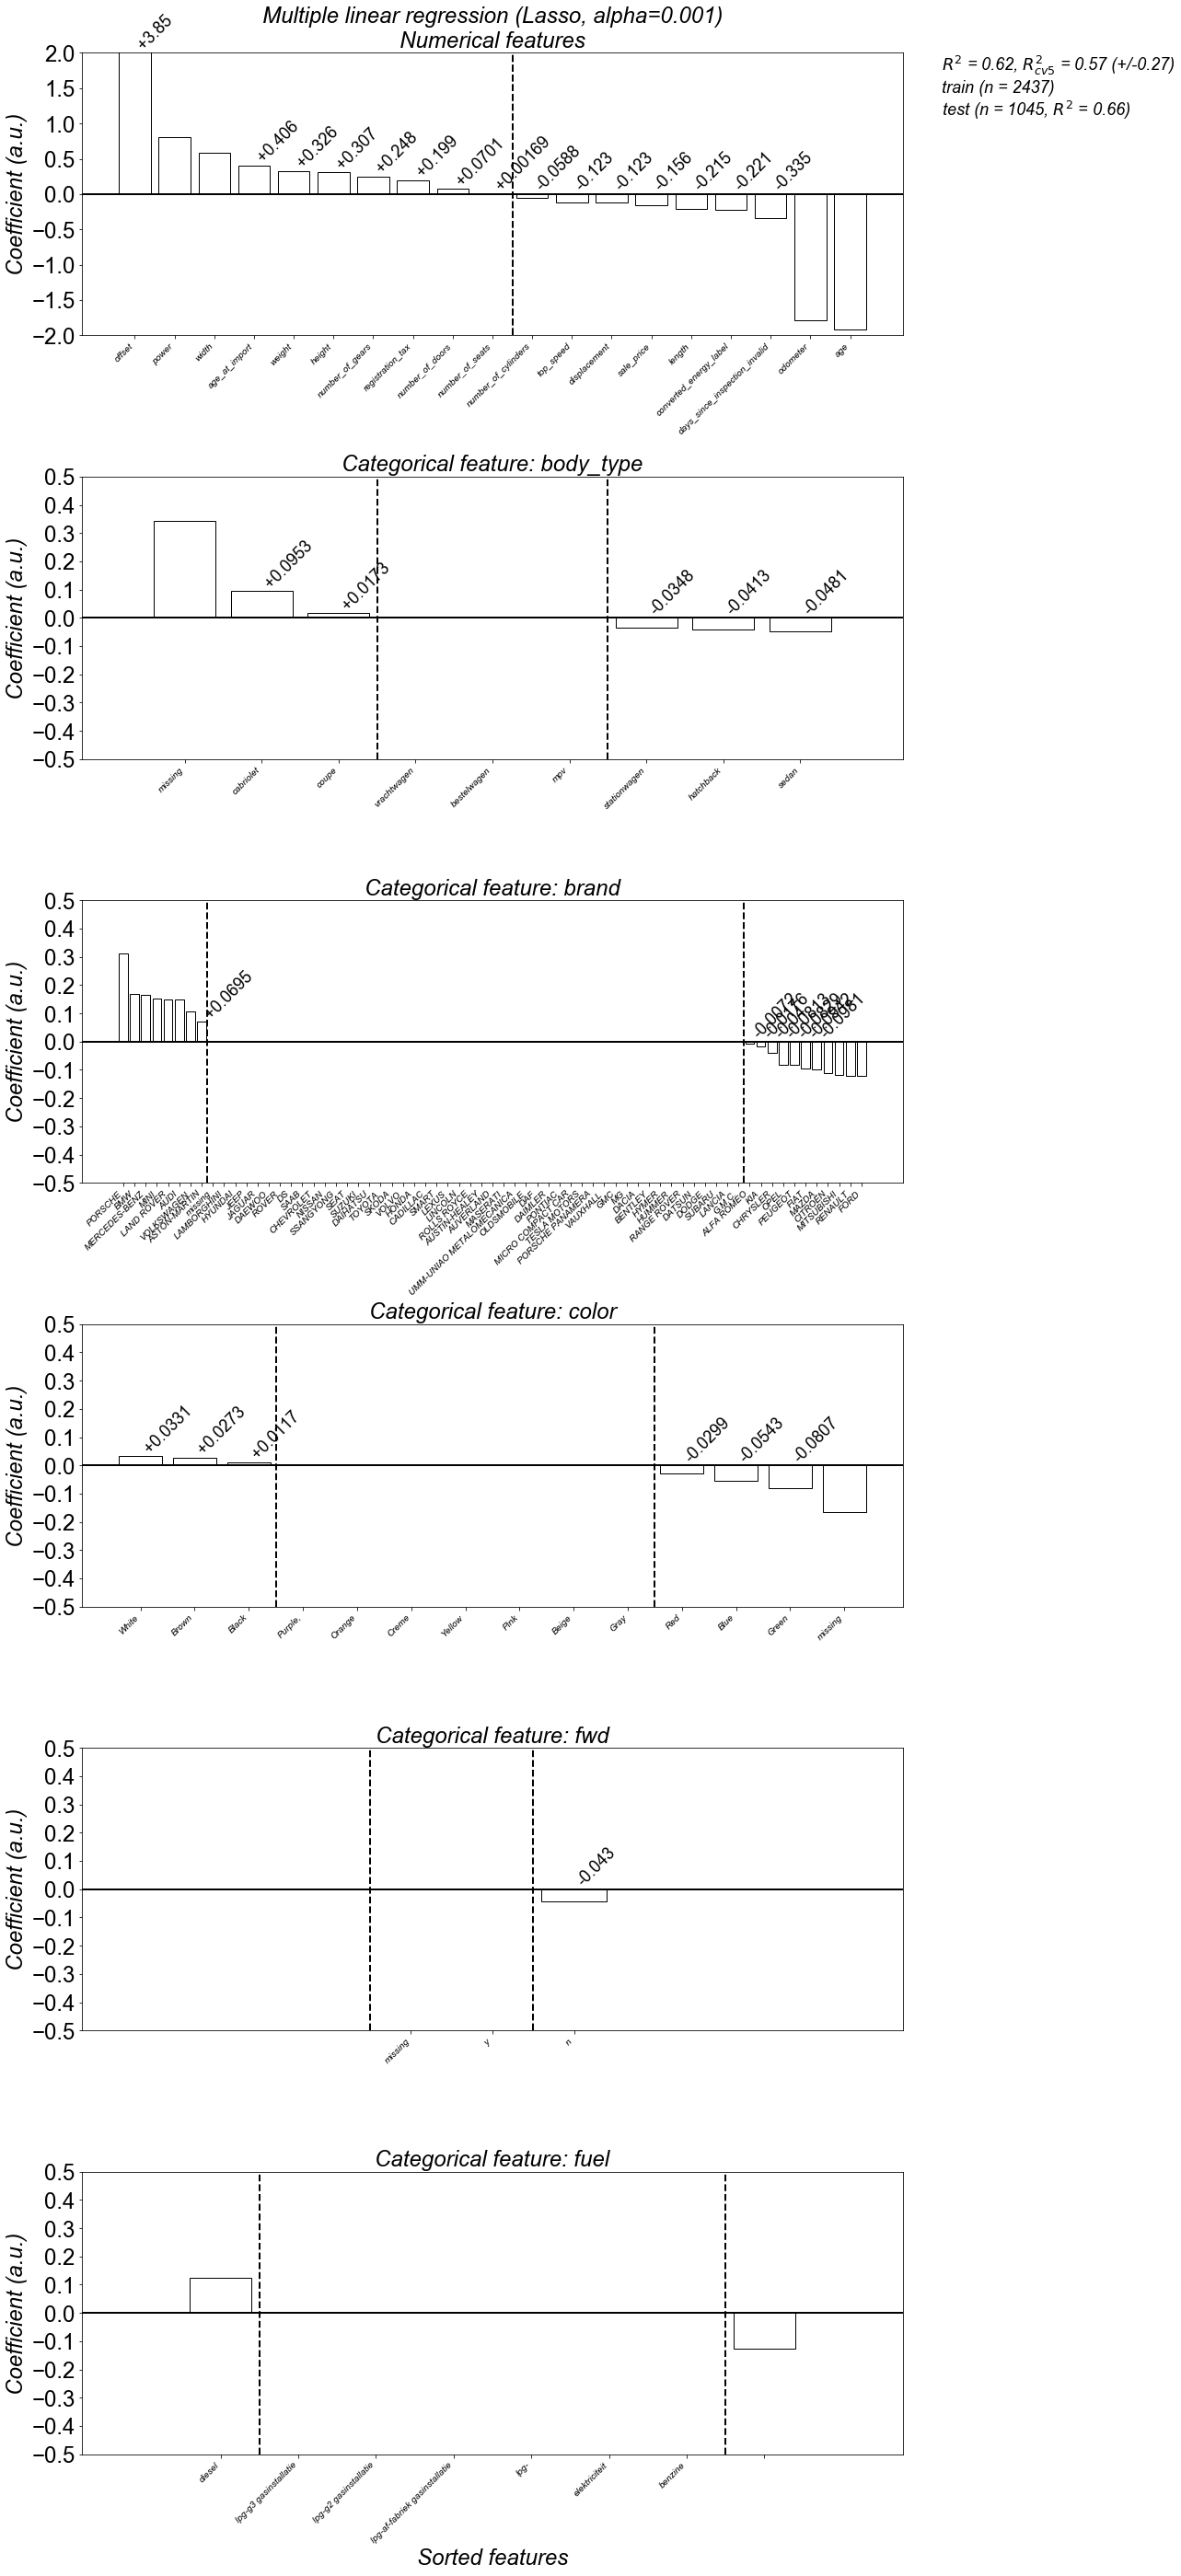

In [38]:
# plot coefficients

# plot numerical and catagorical in different subplots
n_plots = len(cat_columns_reduced) + 1
fig,axs=plt.subplots(
    nrows=n_plots,
    figsize=[16,8*n_plots]
)
plt.subplots_adjust(hspace=0.5)

# Plot coefficients
for feats, coefs, name, ax in zip(
    [['offset'] + features] + cats,
    [[betas[0]] + num_betas] + cat_betas,
    ['numerical'] + cat_columns_reduced,
    axs
):
    # activate subplot axes
    plt.sca(ax)
    # sort by bar height
    x = [feats[i] for i in pd.np.argsort(coefs)[::-1]]
    y = sorted(coefs, reverse=True)
    # plot bar
    plt.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=True)

    # prettify
    if not name.startswith('num'):
        plt.yticks(pd.np.arange(-0.5,+0.6,0.1))
        bot_tick, top_tick = plt.ylim(top=+0.5, bottom=-0.5)
    else:
        plt.yticks(pd.np.arange(-2,2.2,0.5))
        bot_tick, top_tick = plt.ylim(top=+2, bottom=-2)
        # stats
        xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
        plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
            models[model_name]['R^2'],
            models[model_name]['cv R^2'].shape[0],
            pd.np.mean(models[model_name]['cv R^2']),
            pd.np.std(models[model_name]['cv R^2']),
        ) + '\n' +
                 'train (n = {})'.format(y_train.shape[0]) + '\n' +
                 'test (n = {}, $R^2$ = {:.2f})'.format(
                     y_test.shape[0],
                     models[model_name]['test R^2'],
                 ), style='italic', va='top', ha='left')


    # plot sign switch
    x_sign_switch1 = pd.np.nonzero(pd.np.array(y+[-pd.np.inf]) < 0)[0][0]
    x_sign_switch2 = pd.np.nonzero(pd.np.array([+pd.np.inf]+y) > 0)[0][-1]
    plt.axvline(x_sign_switch1-0.5, linewidth=2, linestyle='--', color='k')
    plt.axvline(x_sign_switch2-0.5, linewidth=2, linestyle='--', color='k')
    plt.axhline(0, linewidth=2, linestyle='-', color='k')

    # add values when bar is small or too large (clipping)
    yt,ytl=plt.yticks()
    first_tick = sorted(pd.np.abs(yt))[1]
    for x_val, coef in zip(x,y):
        if (coef < first_tick) & (coef > 0):
            plt.text(x_val, coef, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif (coef > -first_tick) & (coef < 0):
            plt.text(x_val, 0, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif coef > top_tick:
            # generally this is offset (bias)
            plt.text(x_val, top_tick, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif coef < bot_tick:
            # generally this is offset (bias)
            plt.text(x_val, bot_tick, '{:+.3g}'.format(coef), rotation=45, va='top', ha='left')

    
    # labels and titles
    rot = 45
    fsz = 10
    ha = 'right'
    ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
    if not name.startswith('num'):
        plt.title('Categorical feature: ' + name, style='italic')
    else:
        plt.title('Multiple linear regression (Lasso, alpha={:g})\nNumerical features'.format(
            reg.regressor_.named_steps['lasso'].alpha
        ), style='italic') 
    plt.ylabel('Coefficient (a.u.)', style='italic')
    
    # add extra margin if bars are too wide (too little bars)
    if len(x) < 10:
        add_space = len(x) - 10
        xl = list(plt.xlim())
        xl[1] -= add_space/2
        xl[0] += add_space/2
        plt.xlim(xl)

# Label on bottom panel
plt.sca(axs[-1])
plt.xlabel('Sorted features', style='italic')

# Save
plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)


## Model accuracies

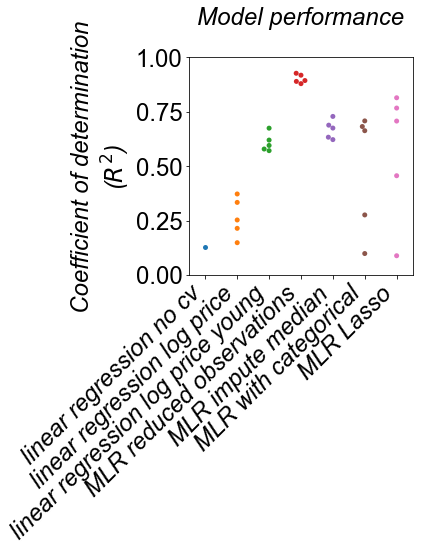

In [39]:
# plot R^2

# counter for x-offset
c=0

# figure
fig = plt.figure(figsize=[4,4])
ax = fig.gca()
xs = ys = [None]

# loop over all models
for name,res in models.items():

    c+=1 # x-offset

    if name == 'linear regression no cv':
        # No cv, so only one value. Make it a list of one for type consistency
        k = 'R^2'
        rsq = [res[k]]
    
    else: 
        k = 'cv R^2'
        rsq = res[k]
        
    # add r-squares and offset to vectors
    ys = pd.np.concatenate([ys,rsq])
    xs = pd.np.concatenate([xs,pd.np.ones_like(rsq) * c])

# actual plotting
sns.swarmplot(x=xs, y=ys, ax=ax)
# prettify
ax.set_xticklabels(models.keys(), rotation=45, va='top', ha='right', style='italic')
ax.set_ylim(bottom=0, top=1)
ax.set_title('Model performance\n', style='italic')
ax.set_ylabel('Coefficient of determination\n($R^2$)', style='italic')


# save
plt.savefig('../results/model-performance.png', bbox_inches='tight', transparent=True)

In [40]:
X = df.loc[:,num_columns].values.reshape(-1,len(num_columns))
y = df.price.values.reshape(-1,1)
print(X.shape)
print(y.shape)

model_name = 'linear regression no cv'
x_ = pd.np.array([ x[0] for x in X ]).reshape(-1,1)
pd.np.nan_to_num(x_, copy=False)
y_pred = models[model_name]['model'].predict(x_)

model_name = 'linear regression log price'
x_ = pd.np.array([ x[0] for x in X ]).reshape(-1,1)
pd.np.nan_to_num(x_, copy=False)
y_pred = models[model_name]['model'].predict(x_)

model_name = 'linear regression log price young'
x_ = pd.np.array([ x[0] for x in X ]).reshape(-1,1)
pd.np.nan_to_num(x_, copy=False)
y_pred = models[model_name]['model'].predict(x_)

model_name = 'MLR reduced observations'
x_ = X.copy()
# pd.np.nan_to_num(x_, copy=False)
x_[pd.isnull(x_)] = 0
y_pred = models[model_name]['model'].predict(x_)

model_name = 'MLR impute median'
x_ = X.copy()
y_pred = models[model_name]['model'].predict(x_)

(4044, 18)
(4044, 1)


linear regression no cv
9144.767738194514
linear regression log price
9369.23226997957
linear regression log price young
8240.261260992731
MLR reduced observations
5877.321931653018
MLR impute median
11043.651765805465
MLR with categorical
7384.819301645068
MLR Lasso
6025.829650453469


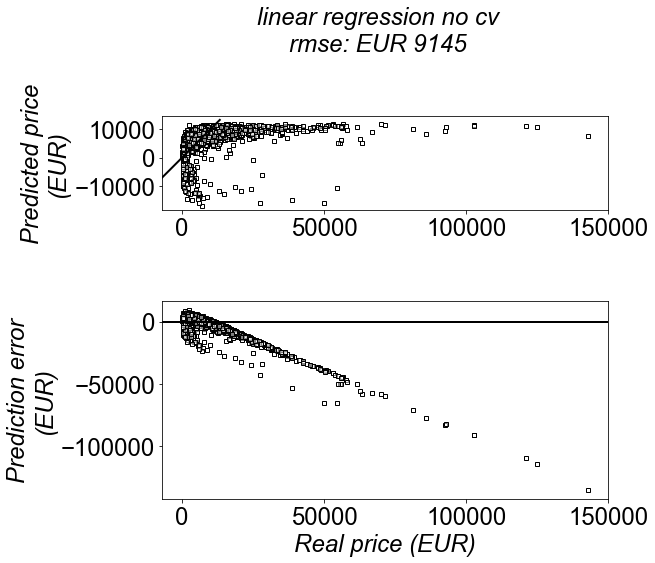

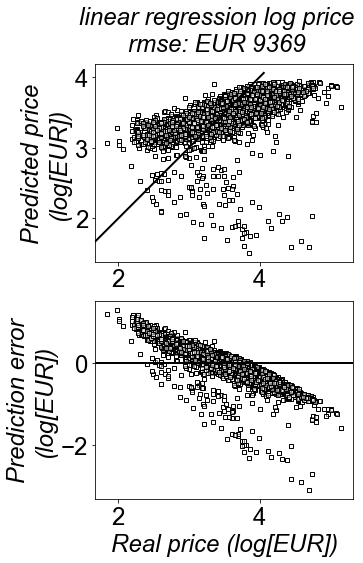

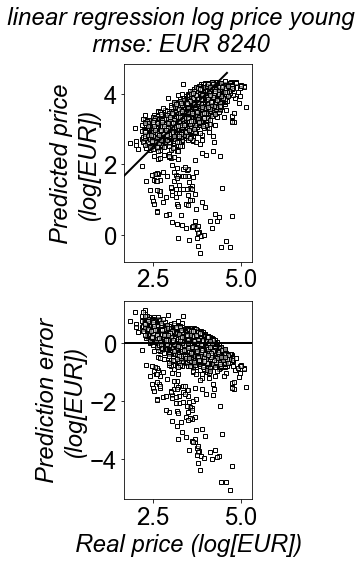

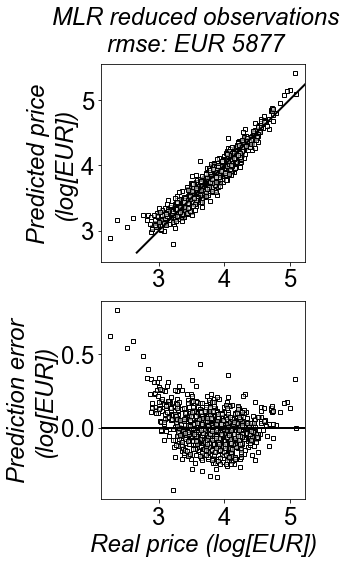

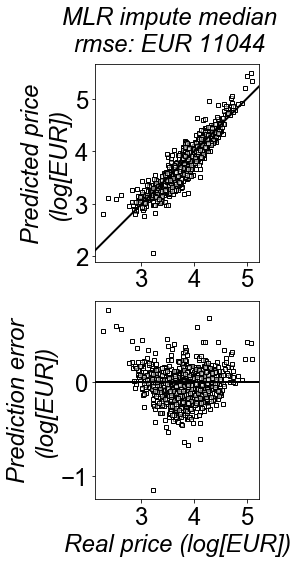

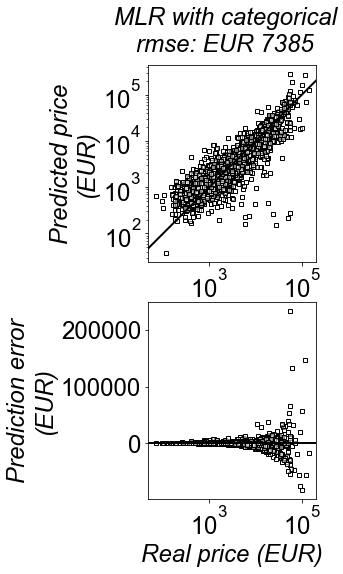

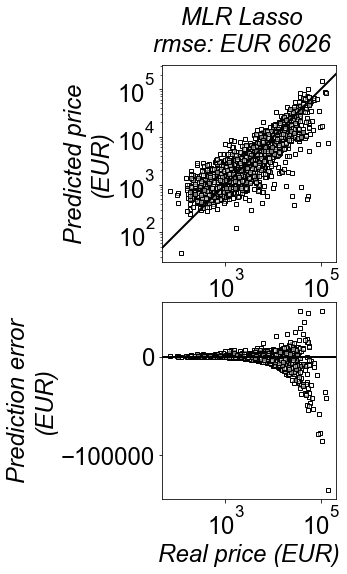

In [41]:
# plot data

# loop over all models
for model_name in models.keys():
    print(model_name)
    res = models[model_name]
    
    # all original data
    yX = df.loc[:,['price', 'age']].dropna()
    X = yX.iloc[:,1]
    y = yX.iloc[:,0]
    
    features = num_columns.copy()
    
    # model specific adjustments
    if (model_name == 'linear regression log price') or (model_name == 'linear regression log price young'):
        # log price is used
        y = pd.np.log10(y)
        # unit
        unit = '(log[EUR])'
    elif (model_name == 'MLR reduced observations') or (model_name == 'MLR impute median'):
        yX = df.dropna(subset=['price'] + features).loc[:,['price'] + features]
        X = yX.iloc[:,1:]
        y = pd.np.log10(yX.iloc[:,0])
        unit = '(log[EUR])'
    elif (model_name == 'MLR with categorical') or (model_name == 'MLR Lasso'):
        yX = df.dropna(subset=['price']).copy()
        X = yX.iloc[:,1:]
        y = yX.iloc[:,0]      
        unit = '(EUR)'
    else:
        unit = '(EUR)'
    
    if X.ndim != 1:
        n_feat = X.shape[1]
    else:
        n_feat = 1
        
    if not ((model_name == 'MLR with categorical') or (model_name == 'MLR Lasso')):
        # needed for .predict
        X = pd.np.array(X).reshape(-1,n_feat)
        y = pd.np.array(y).reshape(-1,1)
    
    # predict all data
    y_pred = res['model'].predict(X)
    if max(y) < 10:
        rmse = pd.np.sqrt(pd.np.mean(((10**y)-(10**y_pred))**2))
    else:
        rmse = pd.np.sqrt(pd.np.mean((y-y_pred)**2))
    print(rmse)

    # actual plotting
    fig,axs = plt.subplots(nrows=2, ncols=1, figsize=[8,8])
    
    # data
    axs[0].plot(y, y_pred, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4,)
    # error
    axs[1].plot(y, y_pred-y, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4,)
    
    # axis equal for top
    if (model_name == 'MLR with categorical') or (model_name == 'MLR Lasso'):
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[1].set_xscale('log')
    axs[0].set_aspect(1)
    # store limits
    yl = axs[0].get_ylim()
    xl_top = axs[0].get_xlim()
    xl_bot = axs[1].get_xlim()
    xl = [pd.np.max([xl_top[0], xl_bot[0]]), pd.np.min([xl_top[1], xl_bot[1]])]
    # plot unity line and 0 error
    unity_line = [pd.np.max([xl[0], yl[0]]), pd.np.min([xl[1], yl[1]])]
    axs[0].plot(unity_line, unity_line, '-k', linewidth=2)
    axs[1].plot(xl, [0, 0], '-k', linewidth=2)
    # reset limits
    axs[0].set_xlim(xl)
    axs[1].set_xlim(xl)

    # make equal size panels
    # Note: sharex did not work
    bb=axs[0].get_position(False)
    rect_top = bb.bounds
    bb=axs[1].get_position(False)
    rect_bot = bb.bounds
    rect = list(rect_bot)
    rect[0] = rect_top[0]
    rect[2] = rect_top[2]
    axs[1].set_position(rect)
    
    # labeling
    fig.suptitle('{}\nrmse: EUR {:.0f}'.format(model_name,rmse), style='italic')
    axs[1].set_xlabel('Real price ' + unit, style='italic')
    axs[0].set_ylabel('Predicted price\n' + unit, style='italic')
    axs[1].set_ylabel('Prediction error\n' + unit, style='italic')
    
    # save
    fig.savefig('../results/{}-accuracy.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)